In [3]:
import arrow
import json
import pandas as pd
import numpy as np
import requests

%matplotlib inline 
import matplotlib.pyplot as plt

In [11]:
#endpoint = 'http://localhost:8000'
endpoint = 'http://electricitymap-api.tmrow.co'
bounding_boxes = {
    'DK': [
        [13.30324, 57.751949], # NE
        [7.60472, 54.509132], # SW
    ],
    'DE': [
        [15.0169958839, 54.983104153],
        [5.98865807458, 47.3024876979]
    ],
    'ES': [
        [4.32788, 43.789959],
        [-9.560789, 36.63546]
    ],
    'PT': [
        [-6.18931, 42.154121],
        [-9.5, 37]
    ]
}
country_codes = bounding_boxes.keys()
start, end = [
    arrow.get(2016, 11, 14),
    arrow.get(2016, 11, 26)
]
time_span = [start]
time_delta = 15 # minutes
while True:
    t = time_span[-1].replace(minutes=+time_delta)
    if t > end: break
    time_span.append(t)

In [12]:
r = requests.session()

In [13]:
def fetch_production(country_code, t):
    url = '%s/v1/production' % endpoint
    params = {
        'countryCode': country_code,
        'datetime': t.to('utc').isoformat()
    }
    obj = r.get(url, params=params).json()
    if not obj: return
    return obj if (t - arrow.get(obj['datetime'])).total_seconds() < time_delta * 60.0 else None
print time_span[-1], fetch_production(country_codes[0], time_span[0])

2016-11-26T00:00:00+00:00 {u'countryCode': u'DE', u'productionDatetime': u'2016-11-14T00:00:00.000Z', u'datetime': u'2016-11-14T00:00:00.000Z', u'production': {u'oil': None, u'nuclear': 10510, u'gas': 2530, u'biomass': 4057, u'coal': 23809, u'solar': 0, u'unknown': 5578, u'wind': 7586, u'hydro': 1387}, u'exchangeDatetime': u'2016-11-14T00:00:00.000Z', u'_id': u'58290baa01e5b48d520f7540'}


In [14]:
# Fetch all country production data
dates = map(lambda t: pd.Timestamp(t.datetime), time_span)
df_wind = pd.DataFrame(columns=country_codes)
df_solar = pd.DataFrame(columns=country_codes)

for country_code in country_codes:
    print 'Fetching %s..' % country_code
    for t in time_span:
        o = fetch_production(country_code, t)
        if not o: continue
        t = arrow.get(o['datetime']).datetime
        if o.get('production', {}).get('wind', None) is not None:
            df_wind.loc[t, country_code] = o['production']['wind']
        if o.get('production', {}).get('solar', None) is not None:
            df_solar.loc[t, country_code] = o['production']['solar']
df_wind = df_wind.sort_index()
df_solar = df_solar.sort_index()
# TODO: write in a cache

Fetching DE..
Fetching DK..
Fetching ES..
Fetching PT..


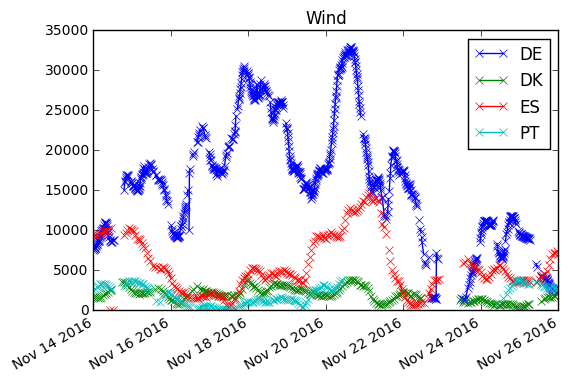

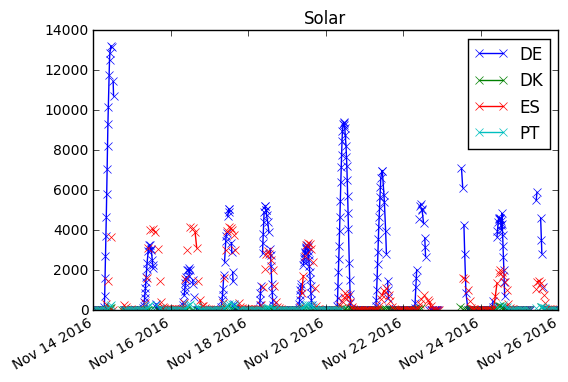

In [15]:
df_wind.plot(marker='x', title='Wind')
df_solar.plot(marker='x', title='Solar')

In [16]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from feeder.parsers import weather

# Force a reload
reload(weather)

def fetch_best_forecast(t):
    return weather.fetch_weather(t, compress=False, useCache=True)

In [17]:
t = time_span[0]
obj = fetch_best_forecast(t)

[12.630003791802473, 14.409531314886383, 18.015198311499027, 8.9003594911815576, 6.3040381464021946, 8.4023626883448976, 5.3320634077484375, 6.2753881864047401, 14.209239854876756, 12.856072073885175, 12.402519402360968, 12.964913529454542, 11.680004235097039, 9.1532342182492563, 9.6531236369933833, 5.0769379131209318, 6.2981029611035177, 14.956259050786581] [50.0, 40.0, 30.0, 50.0, 40.0, 30.0, 60.0, 50.0, 50.0, 60.0, 70.0, 70.0, 70.0, 80.0, 100.0, 70.0, 90.0, 110.0]


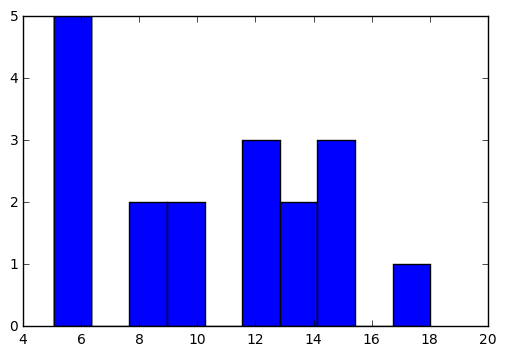

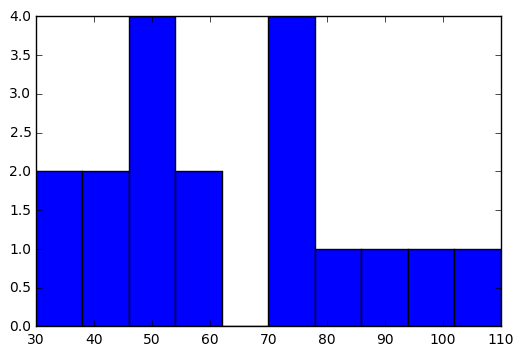

In [18]:
def get_measurements(country_code, t, obj):
    # Return list of measurements inside the country
    header_before = obj['forecasts'][0]['wind'][0]['header']
    header_after  = obj['forecasts'][1]['wind'][0]['header']
    t_before = arrow.get(header_before['refTime']).replace(hours=+header_before['forecastTime'])
    t_after  = arrow.get( header_after['refTime']).replace(hours=+header_after['forecastTime'])

    grid_origin = [header_before['lo1'], header_before['la1']]
    grid_delta = [header_before['dx'], header_before['dy']]
    grid_n = [header_before['nx'], header_before['ny']]

    speeds = []
    dswrfs = []
    bb = bounding_boxes[country_code]

    for i in range(grid_n[0]):
        for j in range(grid_n[1]):
            lon = grid_origin[0] + i * grid_delta[0]
            if lon > 180: lon -= 360
            lat = grid_origin[1] - j * grid_delta[1]
            p = j * grid_n[0] + i
            if lon <= bb[0][0] and lat <= bb[0][1] and \
                lon >= bb[1][0] and lat >= bb[1][1]:
                # We're in the box!
                x = (t.timestamp - t_before.timestamp)/(t_after.timestamp - t_before.timestamp)
                if abs(x) > 1: raise Exception('t is outside of bounds!')
                u = obj['forecasts'][0]['wind'][0]['data'][p] * (1-x) + obj['forecasts'][1]['wind'][0]['data'][p] * x
                v = obj['forecasts'][0]['wind'][1]['data'][p] * (1-x) + obj['forecasts'][1]['wind'][1]['data'][p] * x
                s = obj['forecasts'][0]['solar']['data'][p] * (1-x)   + obj['forecasts'][1]['solar']['data'][p] * x

                speeds.append(np.sqrt(u*u + v*v))
                dswrfs.append(s)
    
    return (speeds, dswrfs)

t = arrow.get(2016, 11, 20, 12, 0)
ws, s = get_measurements('DK', arrow.get(t), fetch_best_forecast(t))
print ws, s
plt.figure()
plt.hist(ws)
plt.figure()
plt.hist(s);

Fetching weather forecast of 2016-11-15T12:00:00+00:00 made at 2016-11-15T06:00:00+00:00
Fetching weather forecast of 2016-11-15T13:00:00+00:00 made at 2016-11-15T06:00:00+00:00
Fetching weather forecast of 2016-11-25T01:00:00+00:00 made at 2016-11-25T00:00:00+00:00
Fetching weather forecast of 2016-11-25T02:00:00+00:00 made at 2016-11-25T00:00:00+00:00
Fetching weather forecast of 2016-11-25T02:00:00+00:00 made at 2016-11-25T00:00:00+00:00
Fetching weather forecast of 2016-11-25T03:00:00+00:00 made at 2016-11-25T00:00:00+00:00
Fetching weather forecast of 2016-11-25T03:00:00+00:00 made at 2016-11-25T00:00:00+00:00
Fetching weather forecast of 2016-11-25T04:00:00+00:00 made at 2016-11-25T00:00:00+00:00
Fetching weather forecast of 2016-11-25T04:00:00+00:00 made at 2016-11-25T00:00:00+00:00
Fetching weather forecast of 2016-11-25T05:00:00+00:00 made at 2016-11-25T00:00:00+00:00
Fetching weather forecast of 2016-11-25T05:00:00+00:00 made at 2016-11-25T00:00:00+00:00
Fetching weather fore

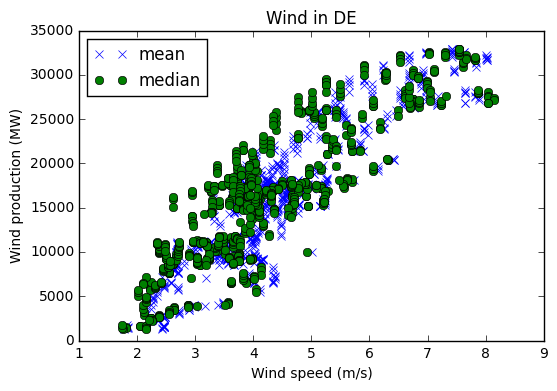

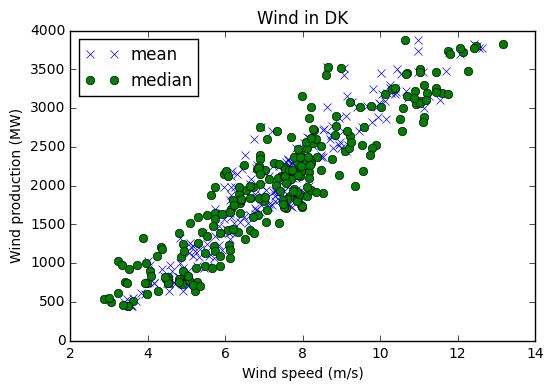

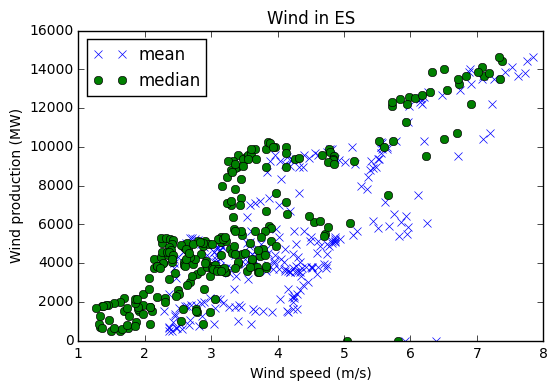

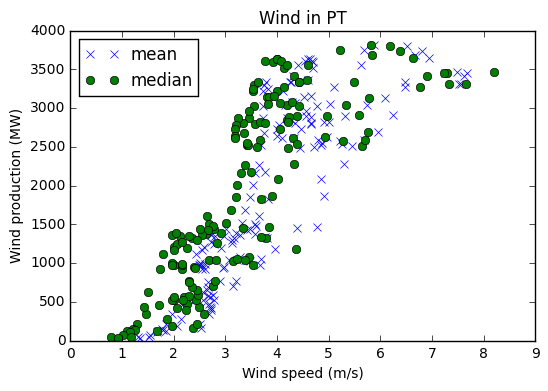

In [19]:
for country_code in country_codes:
    ws_means = []
    ws_medians = []
    ws_maxs = []
    ws_mins = []
    for i in range(len(df_wind)):
        t = arrow.get(df_wind.index[i])
        w_fcast = fetch_best_forecast(t)
        if not w_fcast: 
            print 'Skipping forecast at %s' % t
            continue
        ws, _ = get_measurements(country_code, t, w_fcast)
        ws_means.append(np.mean(ws))
        ws_medians.append(np.median(ws))
        ws_maxs.append(np.max(ws))
        ws_mins.append(np.min(ws))
        
    plt.figure()
    wind_prod = df_wind.loc[:, country_code]
    plt.plot(ws_means, wind_prod, 'x')
    plt.plot(ws_medians, wind_prod, 'o')
    #plt.plot(ws_maxs, wind_prod, '+')
    #plt.plot(ws_mins, wind_prod, 'd')
    plt.title('Wind in %s' % country_code)
    plt.ylabel('Wind production (MW)')
    plt.xlabel('Wind speed (m/s)')
    plt.legend(['mean', 'median'], loc=0)

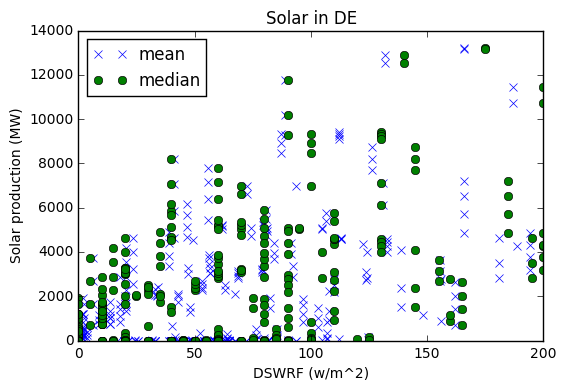

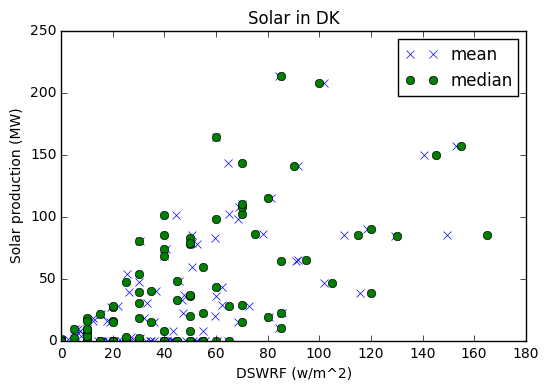

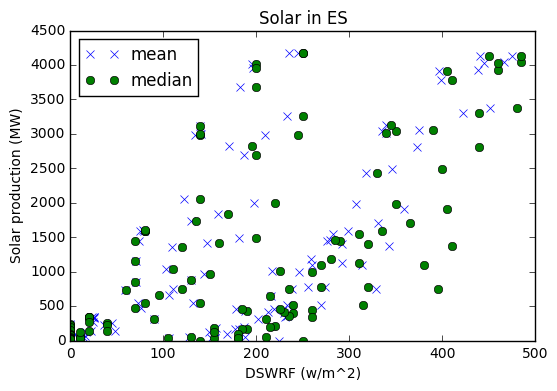

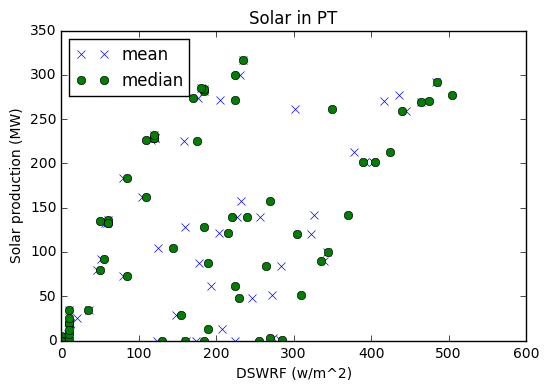

In [20]:
s_means = {}
s_medians = {}
for country_code in country_codes:
    s_means[country_code] = []
    s_medians[country_code] = []
    for i in range(len(df_solar)):
        t = arrow.get(df_solar.index[i])
        s_fcast = fetch_best_forecast(t)
        if not s_fcast: 
            print 'Skipping forecast at %s' % t
            continue
        _, s = get_measurements(country_code, t, s_fcast)
        s_means[country_code].append(np.mean(s))
        s_medians[country_code].append(np.median(s))
    
    plt.figure()
    solar_prod = df_solar.loc[:, country_code]
    plt.plot(s_means[country_code], solar_prod, 'x')
    plt.plot(s_medians[country_code], solar_prod, 'o')
    plt.title('Solar in %s' % country_code)
    plt.ylabel('Solar production (MW)')
    plt.xlabel('DSWRF (w/m^2)')
    plt.legend(['mean', 'median'], loc=0)

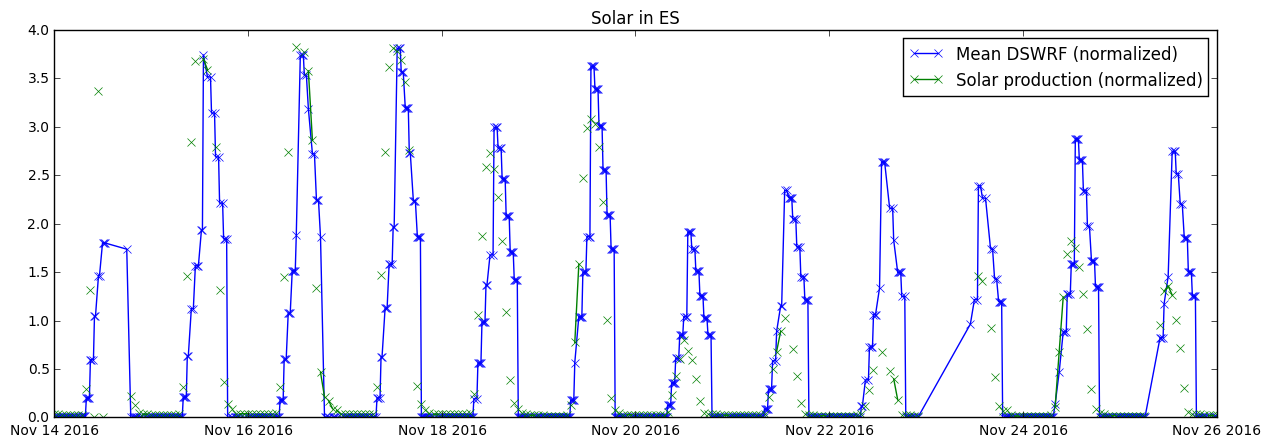

In [29]:
country_code = 'ES'
sigma_s = np.std(s_means[country_code])
sigma_p = np.std(df_solar.loc[:,country_code])
plt.figure(figsize=(15,5))
plt.plot(df_solar.loc[:,country_code].index, np.array(s_means[country_code])/sigma_s, 'x-')
plt.plot(df_solar.loc[:,country_code].index, df_solar.loc[:,country_code]/sigma_p, 'x-')
plt.legend(['Mean DSWRF (normalized)', 'Solar production (normalized)'])
plt.title('Solar in %s' % country_code)